In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
import pyspark.pandas as ps

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .appName('my-cool-app') \
    .getOrCreate()

In [6]:
pip install pyspark[sqlite]

zsh:1: no matches found: pyspark[sqlite]
Note: you may need to restart the kernel to use updated packages.


# 1)Load dataset

In [57]:
# Load in dataset
df = pd.read_csv("/Users/khrishawnpowell/Desktop/Projects/Scansan Properties/PricePaid.csv")


TypeError: 'tuple' object is not callable

### Meaning of column fields
**UniqueTransactionIdentifier** -  A reference number which is generated automatically recording each published sale. The number is unique and will change each time a sale is recorded.

**Price** - 	Sale price stated on the transfer deed.

**DateOfSale** - Date when the sale was completed, as stated on the transfer deed.\

**Postcode** - 	This is the postcode used at the time of the original transaction. Note that postcodes can be reallocated and these changes are not reflected in the Price Paid Dataset.

**PropertyType** - D = Detached, S = Semi-Detached, T = Terraced, F = Flats/Maisonettes, O = Other, end-of-terrace properties are included in the Terraced category above, Other’ is only valid where the transaction relates to a property type that is not covered by existing values, for example where a property comprises more than one large parcel of land

**Old/New** - Indicates the age of the property and applies to all price paid transactions, residential and non-residential.
Y = a newly built property, N = an established residential building

**Duration** - 	Relates to the tenure: F = Freehold, L= Leasehold etc.
Note that HM Land Registry does not record leases of 7 years or less in the Price Paid Dataset.

**PricePaid** - Indicates the type of Price Paid transaction.
A = Standard Price Paid entry, includes single residential property sold for value.
B = Additional Price Paid entry including transfers under a power of sale/repossessions, buy-to-lets (where they can be identified by a Mortgage), transfers to non-private individuals and sales where the property type is classed as ‘Other'

**Record Status** - monthly file only, Indicates additions, changes and deletions to the records.(see guide below).
A = Addition
C = Change
D = Delete

Note that where a transaction changes category type due to misallocation (as above) it will be deleted from the original category type and added to the correct category with a new transaction unique identifier.




# 2)Data cleaning

In [8]:
# Dataset has no headers so have to add them
dfNewColumn = df.set_axis(["UniqueTransactionIdentifier", "Price", "DateOfSale", "Postcode", "PropertyType", "OldNew", "DurationOfTenure", "HouseNumberName", "SecondaryAddress", "Street", "Locality", "TownCity", "District", "County", "PricePaidType", "RecordStatus " ], axis = 1)

In [9]:
# Assign dataset with new columns to df
df = dfNewColumn
df.head()

,UniqueTransactionIdentifier,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County,PricePaidType,RecordStatus
0,{1BA349E3-2579-40D6-999E-49E2A25D2284},73450,1995-10-09 00:00,L26 7XJ,D,Y,F,6,NaN,CATKIN ROAD,LIVERPOOL,LIVERPOOL,KNOWSLEY,MERSEYSIDE,A,A
1,{E5B50DCB-BC7A-4E54-B167-49E2A6B4148B},59000,1995-03-31 00:00,BH12 2AE,D,N,F,28,NaN,ALDER ROAD,POOLE,POOLE,POOLE,POOLE,A,A
2,{81E50116-D675-4B7F-9F8D-49E2B5D43271},31000,1995-12-04 00:00,IP13 0DR,D,Y,F,NONSUCH COTTAGE,NaN,THE STREET,HACHESTON,WOODBRIDGE,SUFFOLK COASTAL,SUFFOLK,A,A
3,{B97455B9-75CB-40BB-A615-42C53683E143},95000,1995-09-22 00:00,WS14 0BE,D,N,F,FOX COVER COTTAGE,NaN,HALL LANE,LICHFIELD,LICHFIELD,LICHFIELD,STAFFORDSHIRE,A,A
4,{F0D1E8DA-C00D-467A-A41C-42C5378DB6E0},45450,1995-02-28 00:00,S42 5GA,S,Y,F,109,NaN,ELVASTON ROAD,NORTH WINGFIELD,CHESTERFIELD,NORTH EAST DERBYSHIRE,DERBYSHIRE,A,A


**Deal with missing values** 
To deal with missing values we will make them the type None this is because in our data as these values are simply just non existent it can be said that empty string.

However during this process I will carry out feature selction to see if we get better accuracy with or without them being empty strings

None will be used as a way to tell our algorithm not to consider invalid or inexistent values on computations.

As 

In [10]:
df.isnull().sum()

UniqueTransactionIdentifier           0
Price                                 0
DateOfSale                            0
Postcode                          44773
PropertyType                          0
OldNew                                0
DurationOfTenure                      0
HouseNumberName                    4191
SecondaryAddress               24482759
Street                           437626
Locality                        9750051
TownCity                              0
District                              0
County                                0
PricePaidType                         0
RecordStatus                          0
dtype: int64

In [11]:
df = df.replace(np.nan, None)

22/12/22 19:02:51 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 217524 ms exceeds timeout 120000 ms
22/12/22 19:02:51 WARN SparkContext: Killing executors is not supported by current scheduler.


In [12]:
df.isnull().sum()

UniqueTransactionIdentifier           0
Price                                 0
DateOfSale                            0
Postcode                          44773
PropertyType                          0
OldNew                                0
DurationOfTenure                      0
HouseNumberName                    4191
SecondaryAddress               24482759
Street                           437626
Locality                        9750051
TownCity                              0
District                              0
County                                0
PricePaidType                         0
RecordStatus                          0
dtype: int64

In [13]:
# Drop the coluimns not required
df = df.drop(["UniqueTransactionIdentifier", "RecordStatus ", "PricePaidType"], axis = 1)

In [14]:
df["DateOfSale"] = df["DateOfSale"].str[:10]

In [15]:
df.head()

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
0,73450,1995-10-09,L26 7XJ,D,Y,F,6,None,CATKIN ROAD,LIVERPOOL,LIVERPOOL,KNOWSLEY,MERSEYSIDE
1,59000,1995-03-31,BH12 2AE,D,N,F,28,None,ALDER ROAD,POOLE,POOLE,POOLE,POOLE
2,31000,1995-12-04,IP13 0DR,D,Y,F,NONSUCH COTTAGE,None,THE STREET,HACHESTON,WOODBRIDGE,SUFFOLK COASTAL,SUFFOLK
3,95000,1995-09-22,WS14 0BE,D,N,F,FOX COVER COTTAGE,None,HALL LANE,LICHFIELD,LICHFIELD,LICHFIELD,STAFFORDSHIRE
4,45450,1995-02-28,S42 5GA,S,Y,F,109,None,ELVASTON ROAD,NORTH WINGFIELD,CHESTERFIELD,NORTH EAST DERBYSHIRE,DERBYSHIRE


In [16]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27734965 entries, 0 to 27734964
Data columns (total 13 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   Price             int64 
 1   DateOfSale        object
 2   Postcode          object
 3   PropertyType      object
 4   OldNew            object
 5   DurationOfTenure  object
 6   HouseNumberName   object
 7   SecondaryAddress  object
 8   Street            object
 9   Locality          object
 10  TownCity          object
 11  District          object
 12  County            object
dtypes: int64(1), object(12)
memory usage: 2.7+ GB


In [17]:
# Change dtype
df.Price.astype("int64")
df.DateOfSale.astype("datetime64")
df.PropertyType.astype("category")
df.OldNew.astype("category")
df.District.astype("category")
df.County.astype("category")
df.Locality.astype("category")


0                 LIVERPOOL
1                     POOLE
2                 HACHESTON
3                 LICHFIELD
4           NORTH WINGFIELD
                 ...       
27734960         STALBRIDGE
27734961         CHICKERELL
27734962          POUNDBURY
27734963                NaN
27734964          STOUR ROW
Name: Locality, Length: 27734965, dtype: category
Categories (23825, object): ['AB KETTLEBY', 'ABBERD', 'ABBERLEY', 'ABBERTON', ..., 'ZONE 1', 'ZONE 2', 'ZONE 3', 'ZOUCH']

In [18]:
london = df.loc[(df["TownCity"] == "LONDON") & (df["Locality"] == "LONDON")] 
london = df.loc[(df["County"] == "GREATER LONDON")]
londonBoroughs = sorted(london.District.unique())
londonBoroughs


['BARKING AND DAGENHAM',
 'BARNET',
 'BEXLEY',
 'BRENT',
 'BROMLEY',
 'CAMDEN',
 'CITY OF LONDON',
 'CITY OF WESTMINSTER',
 'CROYDON',
 'EALING',
 'ENFIELD',
 'GREENWICH',
 'HACKNEY',
 'HAMMERSMITH AND FULHAM',
 'HARINGEY',
 'HARROW',
 'HAVERING',
 'HILLINGDON',
 'HOUNSLOW',
 'ISLINGTON',
 'KENSINGTON AND CHELSEA',
 'KINGSTON UPON THAMES',
 'LAMBETH',
 'LEWISHAM',
 'MERTON',
 'NEWHAM',
 'REDBRIDGE',
 'RICHMOND UPON THAMES',
 'SOUTHWARK',
 'SUTTON',
 'TOWER HAMLETS',
 'WALTHAM FOREST',
 'WANDSWORTH']

Only use year as Date value 

In [19]:
df["DateOfSale"] = pd.DatetimeIndex(df['DateOfSale']).year

# 3)Creation of differnt datasets based on district

In [20]:

psdf = ps.from_pandas(df)
# allBoroughsDf = []
# for i in londonBoroughs:
#     boroughDf = {}
#     x = psdf.loc[psdf["District"] == i]
#     yearDf[i] = x
#     allYearDf.append(yearDf)
    
    

# # allYearDf[23]
# allYearDf[0][cityOfLondonYears[0]]
psdf

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  fields = [
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


22/12/22 19:18:13 WARN TaskSetManager: Stage 0 contains a task of very large size (279647 KiB). The maximum recommended task size is 1000 KiB.


22/12/22 19:18:18 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 0 (TID 0): Attempting to kill Python Worker


,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
0,73450,1995,L26 7XJ,D,Y,F,6,None,CATKIN ROAD,LIVERPOOL,LIVERPOOL,KNOWSLEY,MERSEYSIDE
1,59000,1995,BH12 2AE,D,N,F,28,None,ALDER ROAD,POOLE,POOLE,POOLE,POOLE
2,31000,1995,IP13 0DR,D,Y,F,NONSUCH COTTAGE,None,THE STREET,HACHESTON,WOODBRIDGE,SUFFOLK COASTAL,SUFFOLK
3,95000,1995,WS14 0BE,D,N,F,FOX COVER COTTAGE,None,HALL LANE,LICHFIELD,LICHFIELD,LICHFIELD,STAFFORDSHIRE
4,45450,1995,S42 5GA,S,Y,F,109,None,ELVASTON ROAD,NORTH WINGFIELD,CHESTERFIELD,NORTH EAST DERBYSHIRE,DERBYSHIRE
5,96000,1995,KT17 2DU,S,N,F,82,None,KINGSTON ROAD,EPSOM,EPSOM,EPSOM AND EWELL,SURREY
6,30000,1995,WS10 9LD,S,N,F,66,None,HILL STREET,WEDNESBURY,WEDNESBURY,WALSALL,WEST MIDLANDS
7,425000,1995,KT11 1HP,D,N,F,18,None,BRUNSWICK GROVE,COBHAM,COBHAM,ELMBRIDGE,SURREY
8,89995,1995,WF6 2TT,D,Y,F,8,None,SHAW AVENUE,NORMANTON,NORMANTON,WAKEFIELD,WEST YORKSHIRE
9,40000,1995,NR17 1EY,S,N,F,17,None,WESTFIELDS,ATTLEBOROUGH,ATTLEBOROUGH,BRECKLAND,NORFOLK


**City of London**

In [21]:
cityoflondon = df.loc[df["District"] == londonBoroughs[6]]
cityoflondon

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
3460,108000,1995,EC2Y 8BN,F,Y,L,WILLOUGHBY HOUSE,FLAT 724,BARBICAN,LONDON,LONDON,CITY OF LONDON,GREATER LONDON
6841,90000,1995,EC2Y 8DN,F,N,L,DEFOE HOUSE,FLAT 12,BARBICAN,LONDON,LONDON,CITY OF LONDON,GREATER LONDON
12230,126250,1995,EC2Y 8BX,F,N,L,SEDDON HOUSE,FLAT 411,BARBICAN,LONDON,LONDON,CITY OF LONDON,GREATER LONDON
12626,67000,1995,E1 8RB,F,N,L,MARLYN LODGE,FLAT 510,PORTSOKEN STREET,LONDON,LONDON,CITY OF LONDON,GREATER LONDON
13251,830000,1995,EC4A 1JQ,F,N,F,35,FLAT 9,FURNIVAL STREET,LONDON,LONDON,CITY OF LONDON,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27721053,685000,2022,EC2Y 5AG,F,N,L,ROMAN HOUSE,APARTMENT 34,WOOD STREET,None,LONDON,CITY OF LONDON,GREATER LONDON
27723976,825000,2022,EC2Y 8BX,F,N,L,SEDDON HOUSE,FLAT 401,BARBICAN,None,LONDON,CITY OF LONDON,GREATER LONDON
27725026,850000,2022,EC2Y 8AX,F,N,L,ANDREWES HOUSE,FLAT 17,BARBICAN,None,LONDON,CITY OF LONDON,GREATER LONDON
27732375,1230000,2022,EC2M 4TR,F,N,L,"SHIELD HOUSE, 16",APARTMENT 6,NEW STREET,None,LONDON,CITY OF LONDON,GREATER LONDON


**City of Westminister**

In [22]:
cityoflondon = df.loc[df["District"] == londonBoroughs[7]]
cityoflondon

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
322,147000,1995,W9 2EW,F,N,F,113,FLAT 1-9,SHIRLAND ROAD,LONDON,LONDON,CITY OF WESTMINSTER,GREATER LONDON
429,180000,1995,NW8 9AA,F,N,L,7B,None,ABBEY ROAD,LONDON,LONDON,CITY OF WESTMINSTER,GREATER LONDON
501,136000,1995,W2 2LP,F,Y,L,22,FLAT 4,HYDE PARK PLACE,LONDON,LONDON,CITY OF WESTMINSTER,GREATER LONDON
532,368000,1995,SW1X 7AR,F,N,L,4,None,WILTON MEWS,LONDON,LONDON,CITY OF WESTMINSTER,GREATER LONDON
713,693000,1995,NW1 5HN,F,Y,L,HARLEY HOUSE,FLAT 72,MARYLEBONE ROAD,LONDON,LONDON,CITY OF WESTMINSTER,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27732577,977500,2022,SW1V 4QQ,F,N,L,64A,None,CAMBRIDGE STREET,None,LONDON,CITY OF WESTMINSTER,GREATER LONDON
27732578,1000000,2022,SW1V 3QN,F,N,L,47,FLAT N,ST GEORGES SQUARE,None,LONDON,CITY OF WESTMINSTER,GREATER LONDON
27732579,600000,2022,W2 4UJ,F,N,L,73,THIRD FLOOR FLAT,WESTBOURNE GROVE,None,LONDON,CITY OF WESTMINSTER,GREATER LONDON
27734226,6000000,2022,W1J 8LE,O,N,F,7,None,STRATTON STREET,None,LONDON,CITY OF WESTMINSTER,GREATER LONDON


**Kensington and Chelsea**

In [23]:
kensingtonAndChelsea = df.loc[df["District"] == londonBoroughs[20]]
kensingtonAndChelsea

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
106,64000,1995,SW1X 9PQ,F,N,L,95,THE SECOND FLOOR FLAT AT,SLOANE STREET,LONDON,LONDON,KENSINGTON AND CHELSEA,GREATER LONDON
252,480000,1995,SW5 9QJ,T,N,F,20,None,WEST CROMWELL ROAD,LONDON,LONDON,KENSINGTON AND CHELSEA,GREATER LONDON
497,112000,1995,SW5 9TQ,F,N,L,KENSINGTON MANSIONS,FLAT 33A,TREBOVIR ROAD,LONDON,LONDON,KENSINGTON AND CHELSEA,GREATER LONDON
678,270000,1995,SW5 0DU,F,N,L,COLEHERNE COURT,FLAT 188,REDCLIFFE GARDENS,LONDON,LONDON,KENSINGTON AND CHELSEA,GREATER LONDON
949,150000,1995,W11 2NH,F,N,L,2,BASEMENT AND GROUND FLOOR MAISONETTE,LANSDOWNE CRESCENT,LONDON,LONDON,KENSINGTON AND CHELSEA,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27733760,720000,2022,SW5 9EZ,F,N,L,107,FLAT 3,WARWICK ROAD,None,LONDON,KENSINGTON AND CHELSEA,GREATER LONDON
27733762,671000,2022,W11 3QW,F,N,L,"CAMPDEN HILL TOWERS, 112",FLAT 5,NOTTING HILL GATE,None,LONDON,KENSINGTON AND CHELSEA,GREATER LONDON
27734252,10625000,2022,SW7 2EA,O,N,F,10,None,QUEENSBERRY PLACE,None,LONDON,KENSINGTON AND CHELSEA,GREATER LONDON
27734254,18500000,2022,SW7 5DJ,T,N,F,28,None,HYDE PARK GATE,None,LONDON,KENSINGTON AND CHELSEA,GREATER LONDON


**Hammersmith and Fulham**

In [24]:
hammersmithAndFulham = df.loc[df["District"] == londonBoroughs[13]]
hammersmithAndFulham

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
238,137000,1995,W12 8DW,T,N,F,69,None,PENNARD ROAD,LONDON,LONDON,HAMMERSMITH AND FULHAM,GREATER LONDON
297,112000,1995,SW6 6PP,F,N,L,54,GROUND FLOOR FLAT,GRESWELL STREET,LONDON,LONDON,HAMMERSMITH AND FULHAM,GREATER LONDON
469,145000,1995,W6 0BG,S,N,F,47,None,BRACKENBURY ROAD,LONDON,LONDON,HAMMERSMITH AND FULHAM,GREATER LONDON
476,143000,1995,W14 8QW,F,N,L,PALACE MANSIONS,FLAT 39,EARSBY STREET,LONDON,LONDON,HAMMERSMITH AND FULHAM,GREATER LONDON
485,87500,1995,W14 9JS,F,Y,L,24,FIRST FLOOR FLAT,VEREKER ROAD,LONDON,LONDON,HAMMERSMITH AND FULHAM,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27733765,360000,2022,W12 8NR,F,N,L,69A,None,UXBRIDGE ROAD,None,LONDON,HAMMERSMITH AND FULHAM,GREATER LONDON
27733766,865000,2022,W12 9BG,T,N,F,2,None,WENDELL MEWS,None,LONDON,HAMMERSMITH AND FULHAM,GREATER LONDON
27734235,1900000,2022,SW6 1EH,T,N,F,26,None,BARCLAY ROAD,None,LONDON,HAMMERSMITH AND FULHAM,GREATER LONDON
27734241,712500,2022,SW6 7NF,O,N,F,19,None,PELLANT ROAD,None,LONDON,HAMMERSMITH AND FULHAM,GREATER LONDON


**Wandsworth**

In [25]:
wandsworth = df.loc[df["District"] == londonBoroughs[32]]
wandsworth

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
231,54000,1995,SW17 9AJ,F,N,L,40,None,CHARLMONT ROAD,LONDON,LONDON,WANDSWORTH,GREATER LONDON
270,75000,1995,SW11 3JS,F,N,L,153,THE FIRST AND SECOND FLOOR FLAT,BATTERSEA HIGH STREET,LONDON,LONDON,WANDSWORTH,GREATER LONDON
400,128500,1995,SW18 5DH,T,N,F,149,None,TRENTHAM STREET,LONDON,LONDON,WANDSWORTH,GREATER LONDON
726,130000,1995,SW18 1HP,T,N,F,41,None,SUDLOW ROAD,LONDON,LONDON,WANDSWORTH,GREATER LONDON
790,156500,1995,SW11 1BW,T,N,F,55,None,MALLINSON ROAD,LONDON,LONDON,WANDSWORTH,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27721810,345000,2022,SW17 0PP,F,N,L,140,None,STRATHDON DRIVE,None,LONDON,WANDSWORTH,GREATER LONDON
27721819,530000,2022,SW15 2PW,F,N,L,BURSTOCK LODGE,FLAT 4,BURSTOCK ROAD,None,LONDON,WANDSWORTH,GREATER LONDON
27734247,384000,2022,SW17 9NA,O,N,L,2,None,MITCHAM ROAD,None,LONDON,WANDSWORTH,GREATER LONDON
27734250,30000,2022,SW17 8DL,O,N,F,50,None,MORING ROAD,TOOTING,LONDON,WANDSWORTH,GREATER LONDON


**Lambeth**

In [26]:
lambeth = df.loc[df["District"] == londonBoroughs[22]]
lambeth

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
408,110995,1995,SW8 2PH,F,Y,L,10,41,PRIORY GROVE,LONDON,LONDON,LAMBETH,GREATER LONDON
868,91000,1995,SW4 0SY,F,Y,L,27,None,SYCAMORE MEWS,LONDON,LONDON,LAMBETH,GREATER LONDON
1275,72000,1995,SE11 6SS,F,N,L,KENNETH COURT,FLAT 9,KENNINGTON ROAD,LONDON,LONDON,LAMBETH,GREATER LONDON
1322,77000,1995,SW9 0NS,F,N,L,6,None,CRANWORTH GARDENS,LONDON,LONDON,LAMBETH,GREATER LONDON
1421,59950,1995,SE27 9PJ,T,N,F,16,None,HUBBARD ROAD,LONDON,LONDON,LAMBETH,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27721811,480000,2022,SW16 5BJ,T,N,F,52,None,LARBERT ROAD,None,LONDON,LAMBETH,GREATER LONDON
27721812,1865000,2022,SE1 8YW,F,N,L,"WHITEHOUSE APARTMENTS, 9",FLAT 1225,BELVEDERE ROAD,None,LONDON,LAMBETH,GREATER LONDON
27721813,325000,2022,SW2 3LR,O,N,L,WITLEY HOUSE,FLAT 15,REDLANDS WAY,None,LONDON,LAMBETH,GREATER LONDON
27734239,1800000,2022,SW16 3BS,O,N,F,TUDOR LODGE,None,VOSS COURT,None,LONDON,LAMBETH,GREATER LONDON


**Southwark**

In [27]:
southwark = df.loc[df["District"] == londonBoroughs[28]]
southwark

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
554,160000,1995,SE1 2BB,F,N,L,58,None,NEW CONCORDIA WHARF,LONDON,LONDON,SOUTHWARK,GREATER LONDON
590,66500,1995,SE15 3LY,T,N,F,16,None,NUNHEAD GROVE,LONDON,LONDON,SOUTHWARK,GREATER LONDON
731,57786,1995,SE16 3EZ,F,Y,L,12,FLAT 112,ROSSETTI ROAD,LONDON,LONDON,SOUTHWARK,GREATER LONDON
1159,207800,1995,SE21 7JN,S,N,F,17,None,PICKWICK ROAD,LONDON,LONDON,SOUTHWARK,GREATER LONDON
1542,82000,1995,SE24 9JL,F,N,L,33,FLAT 3,ARDBEG ROAD,LONDON,LONDON,SOUTHWARK,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27721603,1175000,2022,SE1 2ED,F,N,L,137A,None,PROVIDENCE SQUARE,None,LONDON,SOUTHWARK,GREATER LONDON
27721816,387500,2022,SE15 6ED,F,N,L,104,FLAT 4,NEWENT CLOSE,None,LONDON,SOUTHWARK,GREATER LONDON
27734227,560000,2022,SE1 3UH,O,N,F,244,None,BERMONDSEY STREET,None,LONDON,SOUTHWARK,GREATER LONDON
27734234,840000,2022,SE15 5JY,D,N,F,44,None,PECKHAM HILL STREET,None,LONDON,SOUTHWARK,GREATER LONDON


**Tower Hamlets**

In [28]:
towerhamlets = df.loc[df["District"] == londonBoroughs[30]]
towerhamlets

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
119,54000,1995,E3 5NF,F,N,L,42,None,DRIFFIELD ROAD,LONDON,LONDON,TOWER HAMLETS,GREATER LONDON
1115,132000,1995,E14 8EG,F,N,L,25A,None,GOODHART PLACE,LONDON,LONDON,TOWER HAMLETS,GREATER LONDON
1216,80000,1995,E3 4EW,T,N,F,9,None,SPANBY ROAD,LONDON,LONDON,TOWER HAMLETS,GREATER LONDON
2299,195000,1995,E1W 3TF,F,N,L,TRAFALGAR COURT,FLAT 52,WAPPING WALL,LONDON,LONDON,TOWER HAMLETS,GREATER LONDON
2566,65000,1995,E14 3AA,T,N,F,41,None,HARBINGER ROAD,LONDON,LONDON,TOWER HAMLETS,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27734530,945000,2022,E14 3TD,F,N,L,"SLIPWAY HOUSE, 2",FLAT 45,BURRELLS WHARF SQUARE,None,LONDON,TOWER HAMLETS,GREATER LONDON
27734544,557000,2022,E1W 3RY,F,N,L,21,None,MAYNARDS QUAY,None,LONDON,TOWER HAMLETS,GREATER LONDON
27734545,1050000,2022,E14 9XJ,F,N,L,"HOBART BUILDING, 2",FLAT 2702,WARDS PLACE,None,LONDON,TOWER HAMLETS,GREATER LONDON
27734546,290000,2022,E3 3JD,F,N,L,94,None,RAINHILL WAY,None,LONDON,TOWER HAMLETS,GREATER LONDON


**Hackney**

In [29]:
hackney = df.loc[df["District"] == londonBoroughs[12]]
hackney

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
257,62000,1995,E5 0DP,T,N,F,29,None,ASHENDEN ROAD,LONDON,LONDON,HACKNEY,GREATER LONDON
484,65000,1995,E8 4JJ,S,N,F,BENFLEET COURT,18,QUEENSBRIDGE ROAD,LONDON,LONDON,HACKNEY,GREATER LONDON
637,183000,1995,N1 4HR,S,N,F,9,None,CULFORD GROVE,LONDON,LONDON,HACKNEY,GREATER LONDON
867,100000,1995,E5 8NB,T,N,F,92,None,NIGHTINGALE ROAD,LONDON,LONDON,HACKNEY,GREATER LONDON
2122,53000,1995,E8 3BP,F,N,L,6B,None,ST PHILIPS ROAD,LONDON,LONDON,HACKNEY,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27734517,420000,2022,N16 7BH,F,N,L,167,GROUND FLOOR FLAT,EVERING ROAD,None,LONDON,HACKNEY,GREATER LONDON
27734525,545000,2022,N4 2WQ,F,N,L,HARTINGTONS COURT,FLAT 207,COSTER AVENUE,None,LONDON,HACKNEY,GREATER LONDON
27734532,1680000,2022,EC2A 2FG,F,N,L,2,FLAT 4203,PRINCIPAL PLACE,None,LONDON,HACKNEY,GREATER LONDON
27734533,830000,2022,N1 7TX,F,N,L,3,FLAT 18,BRACKLYN STREET,None,LONDON,HACKNEY,GREATER LONDON


**Islington**

In [30]:
islington = df.loc[df["District"] == londonBoroughs[19]]
islington

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
407,157500,1995,N19 5EX,S,N,F,104,None,LADY MARGARET ROAD,LONDON,LONDON,ISLINGTON,GREATER LONDON
795,110000,1995,N19 4PH,F,N,L,21,GROUND FLOOR FLAT,MERCERS ROAD,LONDON,LONDON,ISLINGTON,GREATER LONDON
1195,155000,1995,EC1V 8BR,F,N,L,29 - 31,FLAT 13,DINGLEY PLACE,LONDON,LONDON,ISLINGTON,GREATER LONDON
1471,182500,1995,N1 2YS,T,N,F,1,None,HOPE CLOSE,LONDON,LONDON,ISLINGTON,GREATER LONDON
1492,115000,1995,N7 6AA,T,N,F,42,FLAT,SEVEN SISTERS ROAD,LONDON,LONDON,ISLINGTON,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27734535,355000,2022,N1 3PP,F,N,L,ERIC FLETCHER COURT,FLAT 53,ESSEX ROAD,None,LONDON,ISLINGTON,GREATER LONDON
27734536,425000,2022,N1 8DS,F,N,L,19,None,THESEUS WALK,None,LONDON,ISLINGTON,GREATER LONDON
27734538,540000,2022,N1 3NU,F,N,L,71,FLAT B,NORTHCHURCH ROAD,None,LONDON,ISLINGTON,GREATER LONDON
27734542,470000,2022,N7 0QH,F,N,L,"SOUTHSIDE, 32",FLAT 34,CARLETON ROAD,None,LONDON,ISLINGTON,GREATER LONDON


**Camden**

In [31]:
camden = df.loc[df["District"] == londonBoroughs[5]]
camden

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
1795,58000,1995,NW6 3DY,F,N,L,121,FLAT 2,CANFIELD GARDENS,LONDON,LONDON,CAMDEN,GREATER LONDON
1898,167000,1995,NW5 3HD,T,N,L,20,None,MARSDEN STREET,LONDON,LONDON,CAMDEN,GREATER LONDON
2449,165000,1995,NW6 3EE,F,N,L,98,FLAT 1,CANFIELD GARDENS,LONDON,LONDON,CAMDEN,GREATER LONDON
2661,79000,1995,NW6 2AB,F,N,L,25,GARDEN FLOOR FLAT,HEMSTAL ROAD,LONDON,LONDON,CAMDEN,GREATER LONDON
2728,375000,1995,NW1 9NJ,S,N,F,234,None,ROYAL COLLEGE STREET,LONDON,LONDON,CAMDEN,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27734230,15000,2022,NW2 3QG,O,N,F,2,None,KINGSCROFT ROAD,None,LONDON,CAMDEN,GREATER LONDON
27734231,1325000,2022,NW5 4HX,O,N,F,2,None,SOUTHAMPTON ROAD,None,LONDON,CAMDEN,GREATER LONDON
27734244,985000,2022,WC1H 9QS,O,N,F,"ALBANY HOUSE, 41",None,JUDD STREET,None,LONDON,CAMDEN,GREATER LONDON
27734248,12250,2022,NW6 1BJ,O,N,F,21,None,HOLMDALE ROAD,None,LONDON,CAMDEN,GREATER LONDON


**Brent**

In [32]:
brent = df.loc[df["District"] == "BRENT"]
brent

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
382,118000,1995,HA9 8NW,S,N,F,141,None,PRESTON ROAD,WEMBLEY,WEMBLEY,BRENT,GREATER LONDON
1030,58031,1995,NW2 6RW,F,N,L,78,None,CAMPBELL GORDON WAY,LONDON,LONDON,BRENT,GREATER LONDON
1143,65000,1995,NW10 5SB,F,N,L,25,FIRST FLOOR FLAT,ASHBURNHAM ROAD,LONDON,LONDON,BRENT,GREATER LONDON
1196,123000,1995,HA9 9JY,D,N,F,3,None,EVERSLEY AVENUE,WEMBLEY,WEMBLEY,BRENT,GREATER LONDON
1832,58100,1995,NW2 5PJ,S,N,F,92,None,VILLIERS ROAD,LONDON,LONDON,BRENT,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27733386,1030000,2022,NW6 7TU,F,N,L,44,FLAT 2,WINCHESTER AVENUE,None,LONDON,BRENT,GREATER LONDON
27733541,338000,2022,NW2 4QA,F,N,L,"ERIN COURT, 94",FLAT 20,WALM LANE,None,LONDON,BRENT,GREATER LONDON
27734492,285000,2022,NW2 6AD,F,N,L,68,FLAT F,ANSON ROAD,None,LONDON,BRENT,GREATER LONDON
27734515,450000,2022,NW6 5DQ,F,N,L,"CHASE HOUSE, 1",FLAT 2,HANSEL ROAD,None,LONDON,BRENT,GREATER LONDON


**Ealing**

In [33]:
ealing = df.loc[df["District"] == londonBoroughs[9]]
ealing

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
202,120000,1995,W3 6JN,T,N,F,6,None,EASTBOURNE AVENUE,LONDON,LONDON,EALING,GREATER LONDON
551,60000,1995,W3 6BN,F,N,L,32,None,CROMWELL CLOSE,LONDON,LONDON,EALING,GREATER LONDON
725,138000,1995,W5 4UP,T,N,F,42,None,BLONDIN AVENUE,LONDON,LONDON,EALING,GREATER LONDON
765,63500,1995,W7 2PB,F,N,L,24A,None,GREEN LANE,LONDON,LONDON,EALING,GREATER LONDON
820,101000,1995,W7 3DN,T,N,F,15,None,BROOKBANK AVENUE,LONDON,LONDON,EALING,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27734498,539950,2022,W3 8AA,F,N,L,18,None,BERRYMEAD GARDENS,None,LONDON,EALING,GREATER LONDON
27734519,1000000,2022,W5 4HR,T,N,F,6,None,CONINGSBY ROAD,None,LONDON,EALING,GREATER LONDON
27734521,799950,2022,W5 3PL,F,N,L,15,FLAT 3,GRANGE PARK,None,LONDON,EALING,GREATER LONDON
27734523,500000,2022,W13 0LD,F,N,L,23,None,DRAYTON ROAD,None,LONDON,EALING,GREATER LONDON


**Hounslow**

In [34]:
hounslow = df.loc[df["District"] == londonBoroughs[18]]
hounslow

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
528,178294,1995,TW5 0BY,S,N,F,441,None,GREAT WEST ROAD,HOUNSLOW,HOUNSLOW,HOUNSLOW,GREATER LONDON
560,61000,1995,TW7 7EW,S,Y,F,THE STABLES,4,BANKSIDE CLOSE,ISLEWORTH,ISLEWORTH,HOUNSLOW,GREATER LONDON
562,95000,1995,TW7 4NP,T,N,F,33,None,ST CHRISTOPHERS CLOSE,ISLEWORTH,ISLEWORTH,HOUNSLOW,GREATER LONDON
666,69000,1995,TW3 3SY,S,N,F,19,None,WELLINGTON AVENUE,HOUNSLOW,HOUNSLOW,HOUNSLOW,GREATER LONDON
1021,67500,1995,TW13 4RY,S,N,F,11,None,PORTLAND CRESCENT,FELTHAM,FELTHAM,HOUNSLOW,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27734520,730000,2022,TW7 6PB,S,N,F,11,None,NOTTINGHAM ROAD,None,ISLEWORTH,HOUNSLOW,GREATER LONDON
27734528,1287000,2022,W4 5SB,T,N,F,55,None,THORNEY HEDGE ROAD,None,LONDON,HOUNSLOW,GREATER LONDON
27734543,635000,2022,W4 5UG,F,N,L,MERLIN HOUSE,FLAT 13,BELMONT TERRACE,None,LONDON,HOUNSLOW,GREATER LONDON
27734551,1250000,2022,W4 2UB,T,N,F,24,None,LATTIMER PLACE,None,LONDON,HOUNSLOW,GREATER LONDON


**Richmond upon Thames**

In [35]:
richmondUponThames = df.loc[df["District"] == londonBoroughs[27]]
richmondUponThames

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
160,79000,1995,TW2 6EQ,S,N,F,197,None,POWDER MILL LANE,TWICKENHAM,TWICKENHAM,RICHMOND UPON THAMES,GREATER LONDON
508,68000,1995,TW1 2AU,F,N,L,ARLINGTON COURT,25,ARLINGTON ROAD,TWICKENHAM,TWICKENHAM,RICHMOND UPON THAMES,GREATER LONDON
529,68500,1995,SW13 0EZ,F,N,L,SUSSEX COURT,FLAT 30,GROVE ROAD,LONDON,LONDON,RICHMOND UPON THAMES,GREATER LONDON
604,110000,1995,TW11 0BS,S,N,F,139,None,PARK ROAD,TEDDINGTON,TEDDINGTON,RICHMOND UPON THAMES,GREATER LONDON
748,88500,1995,TW1 1JT,F,N,L,91,None,KENLEY ROAD,TWICKENHAM,TWICKENHAM,RICHMOND UPON THAMES,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27721282,715000,2022,KT1 4DQ,T,N,F,86,None,HIGH STREET,HAMPTON WICK,KINGSTON UPON THAMES,RICHMOND UPON THAMES,GREATER LONDON
27721296,770000,2022,TW11 9AB,T,N,F,4,None,CHRISTCHURCH AVENUE,None,TEDDINGTON,RICHMOND UPON THAMES,GREATER LONDON
27721303,178500,2022,TW4 5NS,F,N,L,680A,None,HANWORTH ROAD,WHITTON,HOUNSLOW,RICHMOND UPON THAMES,GREATER LONDON
27721598,660000,2022,TW1 2TE,F,N,L,"TURNER HOUSE, 26",FLAT 3,CLEVEDON ROAD,None,TWICKENHAM,RICHMOND UPON THAMES,GREATER LONDON


**Kingston Upon Thames**

In [36]:
kingstonUponThames = df.loc[df["District"] == londonBoroughs[21]]
kingstonUponThames

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
552,65250,1995,KT6 6AT,F,Y,L,21,None,LYSANDER GARDENS,SURBITON,SURBITON,KINGSTON UPON THAMES,GREATER LONDON
576,107950,1995,KT9 2GD,D,Y,F,27,None,ARNOLD DRIVE,CHESSINGTON,CHESSINGTON,KINGSTON UPON THAMES,GREATER LONDON
717,92995,1995,KT6 5NX,S,Y,F,13,None,HASTINGS DRIVE,SURBITON,SURBITON,KINGSTON UPON THAMES,GREATER LONDON
1007,118000,1995,KT6 7TY,S,N,F,31,None,ELLERTON ROAD,SURBITON,SURBITON,KINGSTON UPON THAMES,GREATER LONDON
1456,59000,1995,KT2 5NF,T,N,F,64,None,ARCHER CLOSE,KINGSTON UPON THAMES,KINGSTON UPON THAMES,KINGSTON UPON THAMES,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27710283,299995,2022,KT6 7AX,F,N,L,340,FLAT 3,EWELL ROAD,None,SURBITON,KINGSTON UPON THAMES,GREATER LONDON
27710286,2000000,2022,KT3 3RN,O,N,F,226A,None,KINGSTON ROAD,None,NEW MALDEN,KINGSTON UPON THAMES,GREATER LONDON
27710297,5000,2022,KT1 3LU,O,N,L,206,None,CAMBRIDGE ROAD,None,KINGSTON UPON THAMES,KINGSTON UPON THAMES,GREATER LONDON
27712090,350000,2022,KT9 2DT,O,N,F,KINGSCOURT COACHWORKS,None,GREEN LANE,None,CHESSINGTON,KINGSTON UPON THAMES,GREATER LONDON


**Merton** 

In [37]:
merton = df.loc[df["District"] == londonBoroughs[24]]
merton

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
178,90000,1995,SW19 8DT,T,N,F,276,None,DURNSFORD ROAD,LONDON,LONDON,MERTON,GREATER LONDON
383,139950,1995,SW19 8BD,T,N,F,9,None,ALVERSTONE AVENUE,LONDON,LONDON,MERTON,GREATER LONDON
1674,138000,1995,SW19 8BU,T,N,F,77,None,MELROSE AVENUE,LONDON,LONDON,MERTON,GREATER LONDON
2108,82000,1995,SW20 8TG,F,N,L,4,FLAT 3,THE DRIVE,LONDON,LONDON,MERTON,GREATER LONDON
2132,77000,1995,SW19 2DJ,T,N,F,77,None,DENISON ROAD,LONDON,LONDON,MERTON,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27710294,525000,2022,CR4 3GA,S,N,F,7,None,PRESHAW CRESCENT,None,MITCHAM,MERTON,GREATER LONDON
27712096,2870000,2022,SW19 4QN,O,N,F,18A,None,RIDGWAY,None,LONDON,MERTON,GREATER LONDON
27716460,500000,2022,CR4 2EY,T,N,F,41,None,CAITHNESS ROAD,None,MITCHAM,MERTON,GREATER LONDON
27721602,38500000,2022,CR4 2AP,O,N,L,UNIT 19,None,MITCHAM INDUSTRIAL ESTATE,None,MITCHAM,MERTON,GREATER LONDON


**Sutton**

In [38]:
sutton = df.loc[df["District"] == londonBoroughs[29]]
sutton

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
14,59995,1995,SM6 7AG,F,Y,L,55,None,CARAWAY PLACE,WALLINGTON,WALLINGTON,SUTTON,GREATER LONDON
99,75000,1995,SM3 9UL,S,N,F,44,None,CHERTSEY DRIVE,SUTTON,SUTTON,SUTTON,GREATER LONDON
108,87000,1995,SM1 3BH,S,N,F,76,None,ERSKINE ROAD,SUTTON,SUTTON,SUTTON,GREATER LONDON
483,60000,1995,SM5 3DY,S,N,F,21,None,PARK LANE,CARSHALTON,CARSHALTON,SUTTON,GREATER LONDON
752,85000,1995,SM5 4LS,T,N,F,148,None,STANLEY ROAD,CARSHALTON,CARSHALTON,SUTTON,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27712074,225000,2022,CR0 4FA,F,N,L,"WADDON HOUSE, 283",FLAT 12,STAFFORD ROAD,None,CROYDON,SUTTON,GREATER LONDON
27712083,181000,2022,SM6 7JR,F,N,L,24,FLAT 3,FOXGLOVE WAY,None,WALLINGTON,SUTTON,GREATER LONDON
27712092,40000,2022,SM5 3QB,O,N,L,312,None,CARSHALTON ROAD,None,CARSHALTON,SUTTON,GREATER LONDON
27712093,230000,2022,SM5 3NP,O,N,L,77A,None,BANSTEAD ROAD,None,CARSHALTON,SUTTON,GREATER LONDON


**Croydon**

In [39]:
croydon = df.loc[df["District"] == londonBoroughs[8]]
croydon

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
81,77000,1995,SW16 4QD,T,N,F,145,None,STANFORD ROAD,LONDON,LONDON,CROYDON,GREATER LONDON
530,130000,1995,CR2 0RQ,S,N,F,25,None,SUNDOWN AVENUE,SOUTH CROYDON,SOUTH CROYDON,CROYDON,GREATER LONDON
719,64000,1995,CR0 4DB,S,N,F,7,None,PRICE ROAD,CROYDON,CROYDON,CROYDON,GREATER LONDON
985,69500,1995,CR0 4UU,T,Y,F,43,None,KELVIN GARDENS,CROYDON,CROYDON,CROYDON,GREATER LONDON
991,74000,1995,SW16 3SJ,T,N,F,22,None,HOLLMAN GARDENS,LONDON,LONDON,CROYDON,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27712082,260000,2022,SE19 3PZ,F,N,L,27,None,ESKMONT RIDGE,None,LONDON,CROYDON,GREATER LONDON
27712084,210000,2022,SE19 3EQ,F,N,L,36,None,THE WOODLANDS,None,LONDON,CROYDON,GREATER LONDON
27712085,407754,2022,SE19 3UX,F,N,L,"LEWIS HOUSE, 224",FLAT 5,BEULAH HILL,None,LONDON,CROYDON,GREATER LONDON
27712095,440000,2022,CR5 2LA,F,N,L,"CHERRY BLOSSOM COURT, 2",FLAT 6,COULSDON ROAD,None,COULSDON,CROYDON,GREATER LONDON


**Bromley**

In [40]:
bromley = df.loc[df["District"] == londonBoroughs[4]]
bromley

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
64,80000,1995,BR3 3QG,T,N,F,25,None,DERRICK ROAD,BECKENHAM,BECKENHAM,BROMLEY,GREATER LONDON
240,81000,1995,BR2 7JQ,S,N,F,51,None,HURSTDENE AVENUE,BROMLEY,BROMLEY,BROMLEY,GREATER LONDON
874,68000,1995,BR1 3PG,F,N,L,29B,None,LANSDOWNE ROAD,BROMLEY,BROMLEY,BROMLEY,GREATER LONDON
1004,115000,1995,BR5 1JX,S,N,F,113,None,PETTS WOOD ROAD,PETTS WOOD,ORPINGTON,BROMLEY,GREATER LONDON
1181,150000,1995,BR1 3DR,D,N,F,THE TURRET HOUSE,None,SOUTH VIEW,BROMLEY,BROMLEY,BROMLEY,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27714769,490000,2022,BR5 2BG,T,N,F,22,None,BROOKMEAD WAY,None,ORPINGTON,BROMLEY,GREATER LONDON
27714785,845000,2022,BR7 6NX,D,N,F,NEVILLE COTTAGE,None,BULL LANE,None,CHISLEHURST,BROMLEY,GREATER LONDON
27714793,515000,2022,BR6 9RR,S,N,F,4,None,RUSKIN DRIVE,None,ORPINGTON,BROMLEY,GREATER LONDON
27715115,1428000,2022,SE26 6HH,D,N,F,21,None,LAWRIE PARK CRESCENT,None,LONDON,BROMLEY,GREATER LONDON


**Lewisham**

In [41]:
lewisham = df.loc[df["District"] == londonBoroughs[23]]
lewisham

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
46,66500,1995,SE6 4EW,T,N,F,6,None,BROXTED ROAD,LONDON,LONDON,LEWISHAM,GREATER LONDON
598,200500,1995,SE23 2QA,D,N,F,40,None,SUNDERLAND ROAD,LONDON,LONDON,LEWISHAM,GREATER LONDON
1128,59500,1995,SE12 8RF,F,N,L,47A,None,BURNT ASH ROAD,LONDON,LONDON,LEWISHAM,GREATER LONDON
1501,68750,1995,SE23 1QJ,F,Y,L,"VISTA HEIGHTS, 48",FLAT 8,DUNCOMBE HILL,LONDON,LONDON,LEWISHAM,GREATER LONDON
1764,72500,1995,SE23 1NQ,T,N,F,42,None,STILLNESS ROAD,LONDON,LONDON,LEWISHAM,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27721821,265000,2022,SE13 6HX,F,N,L,115B,None,MOUNT PLEASANT ROAD,None,LONDON,LEWISHAM,GREATER LONDON
27721822,204000,2022,SE26 5RT,F,N,L,FAIRLAWN COURT,FLAT 5,FAIRLAWN PARK,None,LONDON,LEWISHAM,GREATER LONDON
27734237,815000,2022,SE26 4QJ,O,N,F,107,None,KIRKDALE,SYDENHAM,LONDON,LEWISHAM,GREATER LONDON
27734245,200000,2022,SE13 7JD,T,N,F,83,None,ALGIERS ROAD,None,LONDON,LEWISHAM,GREATER LONDON


**Greenwich**

In [42]:
greenwich = df.loc[df["District"] == londonBoroughs[11]]
greenwich

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
647,87950,1995,SE18 4PR,F,N,L,ROBERTSON HOUSE,FLAT 5,ROYAL HERBERT PAVILIONS,LONDON,LONDON,GREENWICH,GREATER LONDON
1058,162000,1995,SE3 0AA,F,N,L,11,FLAT 1,MORDEN ROAD,LONDON,LONDON,GREENWICH,GREATER LONDON
1942,89950,1995,SE3 7QG,F,N,L,30,None,PARKSIDE,LONDON,LONDON,GREENWICH,GREATER LONDON
2069,51000,1995,SE9 6NY,S,N,F,25,None,APPLETON ROAD,LONDON,LONDON,GREENWICH,GREATER LONDON
2194,53995,1995,SE7 7UD,F,Y,L,65,None,BERNARD ASHLEY DRIVE,LONDON,LONDON,GREENWICH,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27721820,340000,2022,SE18 1SF,T,N,F,83,None,BARTH ROAD,None,LONDON,GREENWICH,GREATER LONDON
27734229,1650000,2022,SE9 1TD,O,N,F,97 - 101,FIRST AND SECOND FLOORS,ELTHAM HIGH STREET,None,LONDON,GREENWICH,GREATER LONDON
27734246,436500,2022,SE18 7DY,O,N,F,139,None,PLUMSTEAD ROAD,None,LONDON,GREENWICH,GREATER LONDON
27734249,305000,2022,SE18 7PT,T,N,F,10,None,BREWERY ROAD,None,LONDON,GREENWICH,GREATER LONDON


**Bexley**

In [43]:
bexley = df.loc[df["District"] == londonBoroughs[2]]
bexley

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
729,67995,1995,DA7 4BW,T,N,F,19,None,ROWAN ROAD,BEXLEYHEATH,BEXLEYHEATH,BEXLEY,GREATER LONDON
732,76000,1995,DA6 8BN,F,N,L,"SHIRLEY HEIGHTS, 14",9,CROOK LOG,BEXLEYHEATH,BEXLEYHEATH,BEXLEY,GREATER LONDON
786,68500,1995,DA16 3JQ,S,N,F,39,None,LOVEL AVENUE,WELLING,WELLING,BEXLEY,GREATER LONDON
789,85500,1995,DA14 5LT,D,N,F,149,None,NORTH CRAY ROAD,SIDCUP,SIDCUP,BEXLEY,GREATER LONDON
960,67000,1995,DA14 6PN,T,N,F,11,None,NORTHCOTE ROAD,SIDCUP,SIDCUP,BEXLEY,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27712764,452000,2022,DA1 3NR,S,N,F,107,None,HEATH ROAD,CRAYFORD,DARTFORD,BEXLEY,GREATER LONDON
27714755,420000,2022,DA7 5RU,S,N,F,15,None,MARLEY AVENUE,None,BEXLEYHEATH,BEXLEY,GREATER LONDON
27714762,422000,2022,DA16 2DU,S,N,F,149,None,HOOK LANE,None,WELLING,BEXLEY,GREATER LONDON
27714779,395000,2022,DA8 1AJ,S,N,F,2,None,WINIFRED ROAD,None,ERITH,BEXLEY,GREATER LONDON


**Havering**

In [44]:
havering = df.loc[df["District"] == londonBoroughs[16]]
havering

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
42,84000,1995,RM5 3YL,T,N,F,40,None,MOUNT PLEASANT ROAD,ROMFORD,ROMFORD,HAVERING,GREATER LONDON
95,56000,1995,RM1 2DX,T,N,F,1,None,RICHMOND ROAD,ROMFORD,ROMFORD,HAVERING,GREATER LONDON
366,68000,1995,RM5 3XS,S,N,F,219,None,CHASE CROSS ROAD,ROMFORD,ROMFORD,HAVERING,GREATER LONDON
377,60000,1995,RM13 9LD,S,N,F,17,None,PALMERSTON ROAD,RAINHAM,RAINHAM,HAVERING,GREATER LONDON
980,54000,1995,RM3 7HP,T,N,F,5,None,HEATON CLOSE,ROMFORD,ROMFORD,HAVERING,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27733738,260000,2022,RM11 3UL,S,N,L,20,None,BRENDANS CLOSE,None,HORNCHURCH,HAVERING,GREATER LONDON
27733746,701000,2022,RM11 1LB,D,N,F,3,None,SAVOY GROVE,None,HORNCHURCH,HAVERING,GREATER LONDON
27733751,445000,2022,RM1 2BT,T,N,F,12,None,KINGSMEAD AVENUE,None,ROMFORD,HAVERING,GREATER LONDON
27733763,215000,2022,RM12 5NJ,F,N,L,ASTRA COURT WEST,FLAT 40,ASTRA CLOSE,None,HORNCHURCH,HAVERING,GREATER LONDON


**Barking and Dagenham**

In [45]:
barkingAndDagenham = df.loc[df["District"] == londonBoroughs[0]]
barkingAndDagenham

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
1332,73500,1995,IG11 0XG,S,Y,F,21,None,BLESSING WAY,BARKING,BARKING,BARKING AND DAGENHAM,GREATER LONDON
2344,83500,1995,RM6 6AB,T,N,F,31,None,COOMBEWOOD DRIVE,ROMFORD,ROMFORD,BARKING AND DAGENHAM,GREATER LONDON
3176,57000,1995,RM8 2BH,S,N,F,23,None,FIELDWAY,DAGENHAM,DAGENHAM,BARKING AND DAGENHAM,GREATER LONDON
4447,53000,1995,RM10 8UE,F,Y,L,29,None,PLUMTREE CLOSE,DAGENHAM,DAGENHAM,BARKING AND DAGENHAM,GREATER LONDON
6979,50750,1995,IG11 9EN,F,N,L,139,None,WATERSIDE CLOSE,BARKING,BARKING,BARKING AND DAGENHAM,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27721896,353000,2022,IG11 0LA,T,N,F,64,None,CURZON CRESCENT,None,BARKING,BARKING AND DAGENHAM,GREATER LONDON
27721897,370000,2022,RM9 4PJ,T,N,F,121,None,BROMHALL ROAD,None,DAGENHAM,BARKING AND DAGENHAM,GREATER LONDON
27722002,426000,2022,RM8 2SU,S,N,F,4,None,BRYCE ROAD,None,DAGENHAM,BARKING AND DAGENHAM,GREATER LONDON
27722003,490000,2022,RM10 7UH,S,N,F,696,None,DAGENHAM ROAD,None,DAGENHAM,BARKING AND DAGENHAM,GREATER LONDON


**Redbridge**

In [46]:
redbridge = df.loc[df["District"] == londonBoroughs[26]]
redbridge

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
170,73000,1995,IG1 3QJ,T,N,F,2,None,ST HELENS ROAD,ILFORD,ILFORD,REDBRIDGE,GREATER LONDON
278,68500,1995,RM6 4PD,T,N,F,66,None,GROVE ROAD,CHADWELL HEATH,ROMFORD,REDBRIDGE,GREATER LONDON
306,93000,1995,E12 5EF,T,N,F,124,None,WANSTEAD PARK AVENUE,LONDON,LONDON,REDBRIDGE,GREATER LONDON
516,75500,1995,IG3 8QW,T,N,F,4,None,MITCHAM ROAD,ILFORD,ILFORD,REDBRIDGE,GREATER LONDON
745,50500,1995,IG2 7SF,F,N,L,1066,None,EASTERN AVENUE,ILFORD,ILFORD,REDBRIDGE,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27729494,1650000,2022,E11 2JU,S,N,F,48,None,REDBRIDGE LANE WEST,None,LONDON,REDBRIDGE,GREATER LONDON
27729495,488000,2022,IG5 0NB,S,N,F,84,None,WENSLEYDALE AVENUE,None,ILFORD,REDBRIDGE,GREATER LONDON
27733747,257000,2022,IG11 9BZ,F,N,L,615,None,LONGBRIDGE ROAD,None,BARKING,REDBRIDGE,GREATER LONDON
27733748,215000,2022,IG3 9RJ,F,N,L,563A,None,GREEN LANE,None,ILFORD,REDBRIDGE,GREATER LONDON


**Newham**

In [47]:
newham = df.loc[df["District"] == londonBoroughs[25]]
newham

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
2413,82500,1995,E6 5YE,T,N,F,118,None,HALLYWELL CRESCENT,LONDON,LONDON,NEWHAM,GREATER LONDON
2829,53000,1995,E15 3AR,F,Y,L,165,None,JACK CLOW ROAD,LONDON,LONDON,NEWHAM,GREATER LONDON
5313,56500,1995,E16 3NJ,T,N,F,96,None,DEVONSHIRE ROAD,LONDON,LONDON,NEWHAM,GREATER LONDON
5413,77000,1995,E15 1JJ,T,N,F,39,None,MARYLAND ROAD,LONDON,LONDON,NEWHAM,GREATER LONDON
5671,57150,1995,E7 8HN,T,N,F,7,None,ST GEORGES SQUARE,LONDON,LONDON,NEWHAM,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27722139,365000,2022,E7 9NP,F,N,L,"UPTON HEIGHTS, 214",FLAT 44,UPTON LANE,None,LONDON,NEWHAM,GREATER LONDON
27722147,325940,2022,E15 4QR,F,N,L,"AMMONITE HOUSE, 12",FLAT 54,FLINT CLOSE,None,LONDON,NEWHAM,GREATER LONDON
27722149,480000,2022,E16 1BA,F,N,L,"THE GRAINSTORE, 4",FLAT 49,WESTERN GATEWAY,None,LONDON,NEWHAM,GREATER LONDON
27722151,470000,2022,E13 8RX,T,N,F,31,None,WOODSIDE ROAD,None,LONDON,NEWHAM,GREATER LONDON


**Waltham Forest**

In [48]:
walthamForest = df.loc[df["District"] == londonBoroughs[31]]
walthamForest

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
546,60000,1995,E17 6RD,T,N,F,15,None,ROSEBANK GROVE,LONDON,LONDON,WALTHAM FOREST,GREATER LONDON
1452,54000,1995,E10 5DH,T,N,F,68,None,FARMER ROAD,LONDON,LONDON,WALTHAM FOREST,GREATER LONDON
2098,55950,1995,E17 5LR,S,N,F,217,None,WINNS AVENUE,WALTHAMSTOW,LONDON,WALTHAM FOREST,GREATER LONDON
2123,58000,1995,E10 5LT,T,N,F,3,None,WILMOT ROAD,LONDON,LONDON,WALTHAM FOREST,GREATER LONDON
2913,71000,1995,E17 3PG,S,N,F,25,None,FORESTERS DRIVE,LONDON,LONDON,WALTHAM FOREST,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27733536,395000,2022,E10 5ET,F,N,L,137A,None,GRANGE PARK ROAD,None,LONDON,WALTHAM FOREST,GREATER LONDON
27733538,1087000,2022,E17 4SN,T,N,F,43,None,BYRON ROAD,None,LONDON,WALTHAM FOREST,GREATER LONDON
27733539,1095000,2022,E17 4SN,T,N,F,41,None,BYRON ROAD,None,LONDON,WALTHAM FOREST,GREATER LONDON
27734511,487000,2022,E17 5HA,F,N,L,118,None,WINNS AVENUE,WALTHAMSTOW,LONDON,WALTHAM FOREST,GREATER LONDON


**Haringey**

In [49]:
haringey = df.loc[df["District"] == londonBoroughs[14]]
haringey

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
61,67995,1995,N22 6NP,T,N,F,155,None,MORLEY AVENUE,LONDON,LONDON,HARINGEY,GREATER LONDON
197,243000,1995,N8 9AU,T,N,F,92,None,CECILE PARK,LONDON,LONDON,HARINGEY,GREATER LONDON
706,64000,1995,N15 6JT,T,N,F,76,None,LEALAND ROAD,LONDON,LONDON,HARINGEY,GREATER LONDON
730,425000,1995,N6 4RA,S,N,F,60,None,TALBOT ROAD,HIGHGATE,LONDON,HARINGEY,GREATER LONDON
836,80000,1995,N17 6UR,T,N,F,109,None,BRUCE GROVE,LONDON,LONDON,HARINGEY,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27734516,346400,2022,N4 4QJ,F,N,L,164,FLAT D,STAPLETON HALL ROAD,None,LONDON,HARINGEY,GREATER LONDON
27734518,230000,2022,N22 5JH,F,N,L,618D,None,LORDSHIP LANE,None,LONDON,HARINGEY,GREATER LONDON
27734529,314000,2022,N15 4DR,F,N,L,BEAUFORT HOUSE,FLAT 2,TALBOT ROAD,SOUTH TOTTENHAM,LONDON,HARINGEY,GREATER LONDON
27734539,385000,2022,N4 4JL,F,N,L,GRANVILLE COURT,FLAT 25,MOUNT VIEW ROAD,None,LONDON,HARINGEY,GREATER LONDON


**Enfield**

In [50]:
enfield = df.loc[df["District"] == londonBoroughs[9]]
enfield

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
202,120000,1995,W3 6JN,T,N,F,6,None,EASTBOURNE AVENUE,LONDON,LONDON,EALING,GREATER LONDON
551,60000,1995,W3 6BN,F,N,L,32,None,CROMWELL CLOSE,LONDON,LONDON,EALING,GREATER LONDON
725,138000,1995,W5 4UP,T,N,F,42,None,BLONDIN AVENUE,LONDON,LONDON,EALING,GREATER LONDON
765,63500,1995,W7 2PB,F,N,L,24A,None,GREEN LANE,LONDON,LONDON,EALING,GREATER LONDON
820,101000,1995,W7 3DN,T,N,F,15,None,BROOKBANK AVENUE,LONDON,LONDON,EALING,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27734498,539950,2022,W3 8AA,F,N,L,18,None,BERRYMEAD GARDENS,None,LONDON,EALING,GREATER LONDON
27734519,1000000,2022,W5 4HR,T,N,F,6,None,CONINGSBY ROAD,None,LONDON,EALING,GREATER LONDON
27734521,799950,2022,W5 3PL,F,N,L,15,FLAT 3,GRANGE PARK,None,LONDON,EALING,GREATER LONDON
27734523,500000,2022,W13 0LD,F,N,L,23,None,DRAYTON ROAD,None,LONDON,EALING,GREATER LONDON


**Barnet**

In [51]:
barnet = df.loc[df["District"] == londonBoroughs[1]]
barnet

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
82,74950,1995,NW2 2AA,S,N,F,42,None,CREWYS ROAD,LONDON,LONDON,BARNET,GREATER LONDON
352,63000,1995,N11 1JS,T,N,F,35,None,FALKLAND AVENUE,LONDON,LONDON,BARNET,GREATER LONDON
398,121250,1995,N12 8LR,F,N,L,CAVENDISH HOUSE,FLAT 20,WOODSIDE GRANGE ROAD,LONDON,LONDON,BARNET,GREATER LONDON
461,90000,1995,N12 9EA,T,N,F,80,None,GROVE ROAD,LONDON,LONDON,BARNET,GREATER LONDON
617,66500,1995,HA8 0DZ,S,N,F,151,None,MONTROSE AVENUE,EDGWARE,EDGWARE,BARNET,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27733532,600000,2022,N12 9ET,F,N,L,45A,FLAT 2,WOODHOUSE ROAD,None,LONDON,BARNET,GREATER LONDON
27734495,558000,2022,NW2 3LL,F,N,L,10A,None,ASH GROVE,None,LONDON,BARNET,GREATER LONDON
27734534,340000,2022,NW7 3HR,F,N,L,118,None,THE FAIRWAY,None,LONDON,BARNET,GREATER LONDON
27734547,1150000,2022,N10 1HG,T,N,F,56,None,SUTTON ROAD,None,LONDON,BARNET,GREATER LONDON


**Barnet**

In [52]:
barnet = df.loc[df["District"] == londonBoroughs[1]]
barnet

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
82,74950,1995,NW2 2AA,S,N,F,42,None,CREWYS ROAD,LONDON,LONDON,BARNET,GREATER LONDON
352,63000,1995,N11 1JS,T,N,F,35,None,FALKLAND AVENUE,LONDON,LONDON,BARNET,GREATER LONDON
398,121250,1995,N12 8LR,F,N,L,CAVENDISH HOUSE,FLAT 20,WOODSIDE GRANGE ROAD,LONDON,LONDON,BARNET,GREATER LONDON
461,90000,1995,N12 9EA,T,N,F,80,None,GROVE ROAD,LONDON,LONDON,BARNET,GREATER LONDON
617,66500,1995,HA8 0DZ,S,N,F,151,None,MONTROSE AVENUE,EDGWARE,EDGWARE,BARNET,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27733532,600000,2022,N12 9ET,F,N,L,45A,FLAT 2,WOODHOUSE ROAD,None,LONDON,BARNET,GREATER LONDON
27734495,558000,2022,NW2 3LL,F,N,L,10A,None,ASH GROVE,None,LONDON,BARNET,GREATER LONDON
27734534,340000,2022,NW7 3HR,F,N,L,118,None,THE FAIRWAY,None,LONDON,BARNET,GREATER LONDON
27734547,1150000,2022,N10 1HG,T,N,F,56,None,SUTTON ROAD,None,LONDON,BARNET,GREATER LONDON


**Harrow**

In [53]:
harrow = df.loc[df["District"] == londonBoroughs[15]]
harrow

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
35,292500,1995,HA3 6DD,D,Y,F,11,None,LAVENDER GARDENS,HARROW WEALD,HARROW,HARROW,GREATER LONDON
112,82950,1995,HA2 6NH,S,N,F,10,None,BROADFIELDS,HARROW,HARROW,HARROW,GREATER LONDON
744,73000,1995,HA3 9HR,S,N,F,115,None,CHARLTON ROAD,HARROW,HARROW,HARROW,GREATER LONDON
1025,58000,1995,HA3 7SN,T,N,F,86A,None,CANNING ROAD,HARROW,HARROW,HARROW,GREATER LONDON
1158,88950,1995,HA5 3PR,F,Y,L,"SKILLEN LODGE, 552",FLAT 7,UXBRIDGE ROAD,PINNER,PINNER,HARROW,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27733514,345000,2022,HA2 0NB,F,N,L,39A,None,BROOKE AVENUE,None,HARROW,HARROW,GREATER LONDON
27733528,400000,2022,HA1 1SA,F,N,L,43A,None,RADNOR ROAD,None,HARROW,HARROW,GREATER LONDON
27734494,325000,2022,HA7 4ND,F,N,L,KELMSCOTT COURT,1,ARAN DRIVE,None,STANMORE,HARROW,GREATER LONDON
27734522,305000,2022,HA7 2SR,F,N,L,MENTMORE COURT,81,SEPTEMBER WAY,None,STANMORE,HARROW,GREATER LONDON


**Hillingdon**

In [54]:
hillingdon = df.loc[df["District"] == londonBoroughs[17]]
hillingdon

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
188,51000,1995,UB8 2UW,F,N,L,6A,None,ROCKINGHAM PARADE,UXBRIDGE,UXBRIDGE,HILLINGDON,GREATER LONDON
194,82500,1995,UB4 9TH,S,Y,F,36,None,TELFORD WAY,HAYES,HAYES,HILLINGDON,GREATER LONDON
447,124500,1995,UB8 3AL,S,N,F,19,None,CLAYTON WAY,UXBRIDGE,UXBRIDGE,HILLINGDON,GREATER LONDON
583,125000,1995,UB4 8NX,D,N,F,136,None,POLE HILL ROAD,HAYES,HAYES,HILLINGDON,GREATER LONDON
733,156250,1995,UB8 2PS,D,N,F,50,None,ELTHORNE ROAD,UXBRIDGE,UXBRIDGE,HILLINGDON,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27734506,470000,2022,UB4 9HU,T,N,F,124,None,GREENWAY,None,HAYES,HILLINGDON,GREATER LONDON
27734507,135000,2022,HA4 8FX,F,N,L,"POUNDEN COURT, 6",FLAT 8,AITKEN CLOSE,None,RUISLIP,HILLINGDON,GREATER LONDON
27734514,355000,2022,UB9 6HD,F,N,L,7,None,SPRING CLOSE,HAREFIELD,UXBRIDGE,HILLINGDON,GREATER LONDON
27734526,328000,2022,HA4 8FA,F,N,L,"CORINTHIAN COURT, 1",FLAT 36,STATION APPROACH,None,RUISLIP,HILLINGDON,GREATER LONDON


# 4)Data Exploration


### City of London

In [55]:
cityOfLondonYears = cityoflondon.DateOfSale.unique()
allYearDf =[]

for i in cityOfLondonYears:
    yearDf = {}
    x = cityoflondon.loc[cityoflondon["DateOfSale"] == i]
    yearDf[i] = x
    allYearDf.append(yearDf)
    
    

# allYearDf[23]
allYearDf[0][cityOfLondonYears[0]]
    

,Price,DateOfSale,Postcode,PropertyType,OldNew,DurationOfTenure,HouseNumberName,SecondaryAddress,Street,Locality,TownCity,District,County
322,147000,1995,W9 2EW,F,N,F,113,FLAT 1-9,SHIRLAND ROAD,LONDON,LONDON,CITY OF WESTMINSTER,GREATER LONDON
429,180000,1995,NW8 9AA,F,N,L,7B,None,ABBEY ROAD,LONDON,LONDON,CITY OF WESTMINSTER,GREATER LONDON
501,136000,1995,W2 2LP,F,Y,L,22,FLAT 4,HYDE PARK PLACE,LONDON,LONDON,CITY OF WESTMINSTER,GREATER LONDON
532,368000,1995,SW1X 7AR,F,N,L,4,None,WILTON MEWS,LONDON,LONDON,CITY OF WESTMINSTER,GREATER LONDON
713,693000,1995,NW1 5HN,F,Y,L,HARLEY HOUSE,FLAT 72,MARYLEBONE ROAD,LONDON,LONDON,CITY OF WESTMINSTER,GREATER LONDON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
796040,60000,1995,W2 2QG,F,N,L,PARK WEST,47,EDGWARE ROAD,LONDON,LONDON,CITY OF WESTMINSTER,GREATER LONDON
796140,250000,1995,NW1 6UP,T,N,F,127,None,LISSON GROVE,LONDON,LONDON,CITY OF WESTMINSTER,GREATER LONDON
796184,95000,1995,W9 2DR,F,N,L,58,FLAT 4,MARYLANDS ROAD,LONDON,LONDON,CITY OF WESTMINSTER,GREATER LONDON
796313,69000,1995,NW8 9BU,F,N,L,"ABBEY HOUSE, 1A",FLAT 31,ABBEY ROAD,LONDON,LONDON,CITY OF WESTMINSTER,GREATER LONDON


In [56]:
for i in range(len(allYearDf)):

SyntaxError: incomplete input (3753935044.py, line 1)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


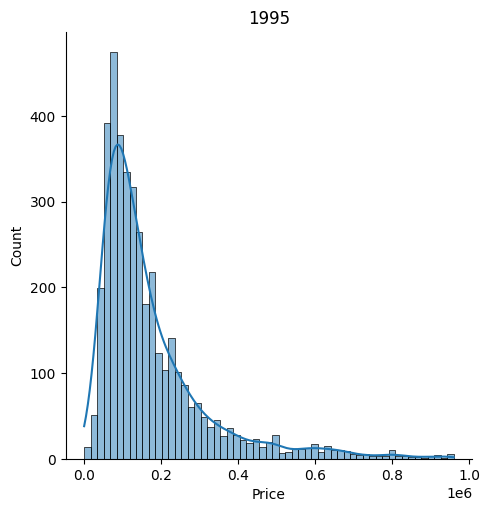

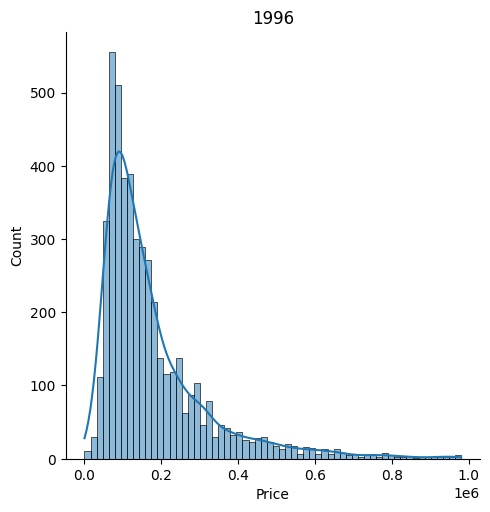

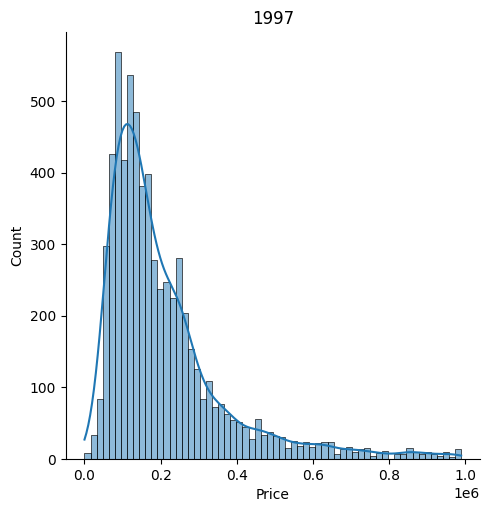

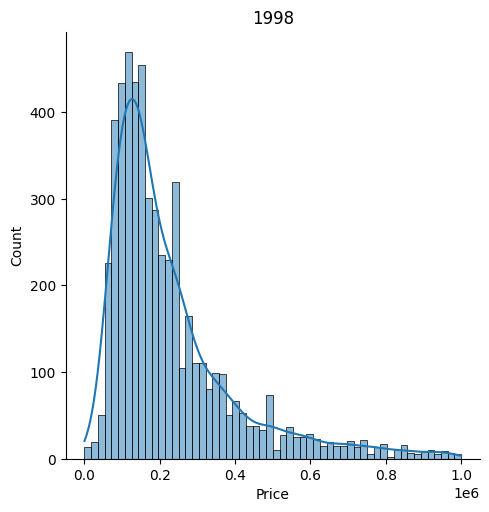

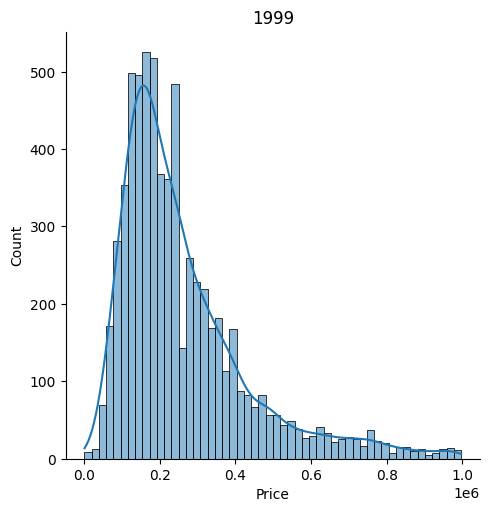

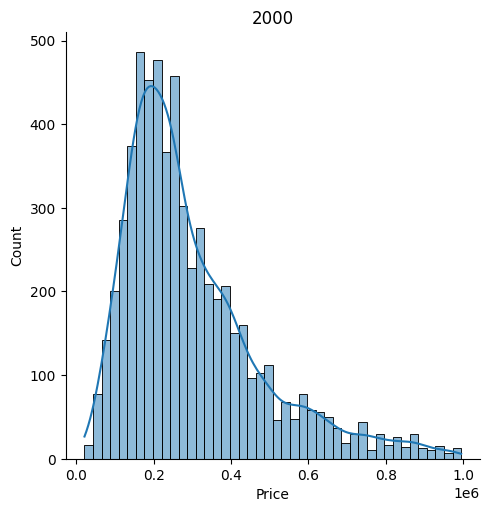

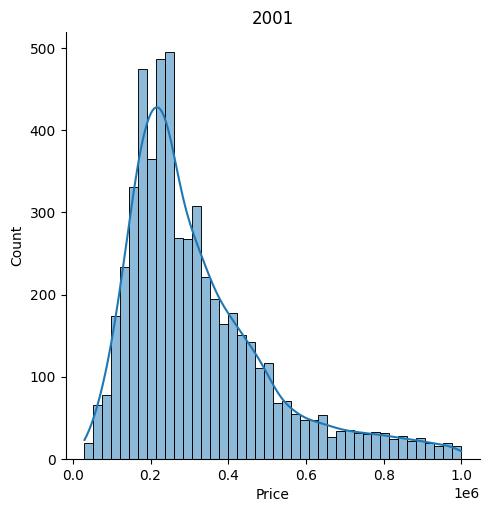

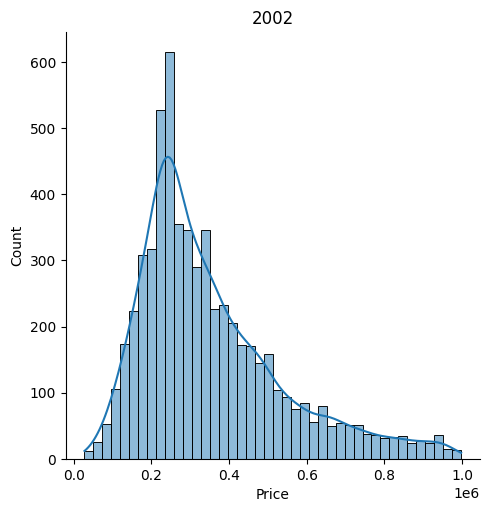

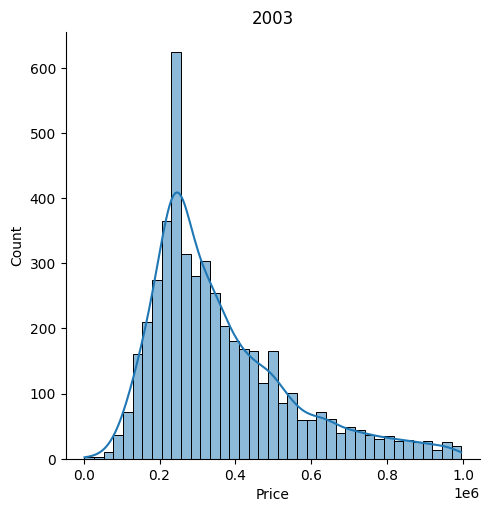

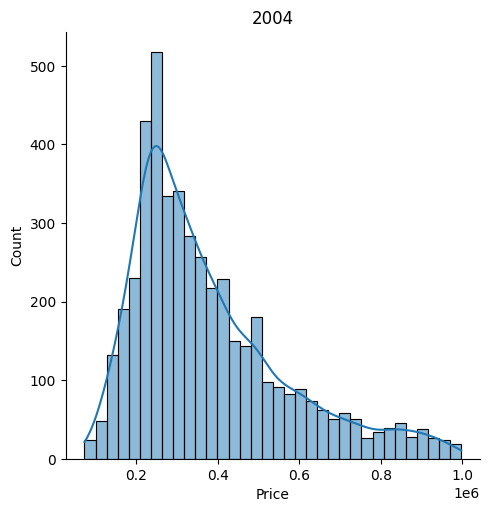

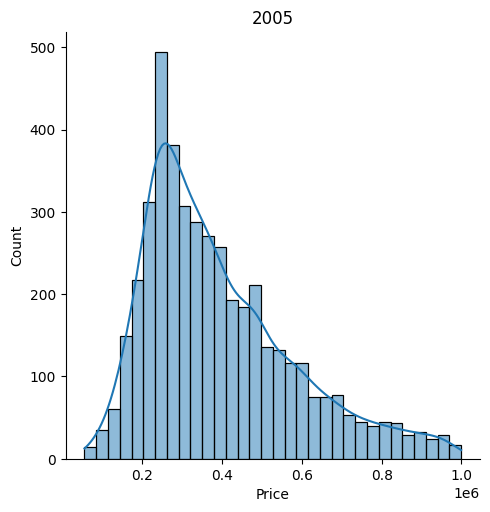

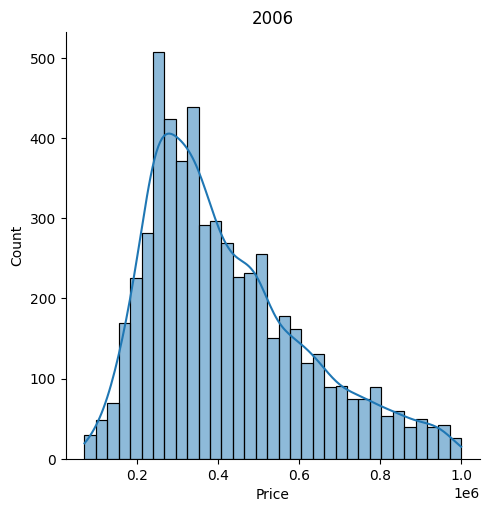

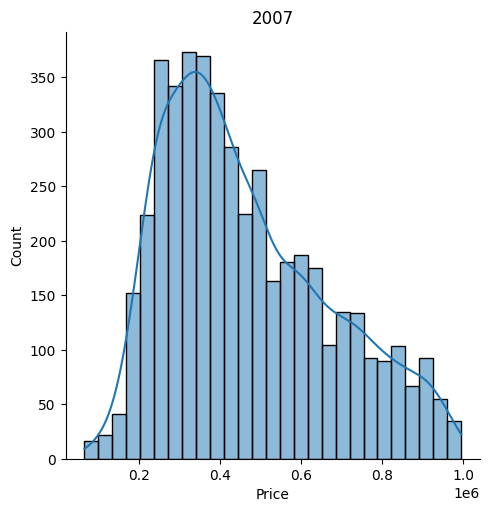

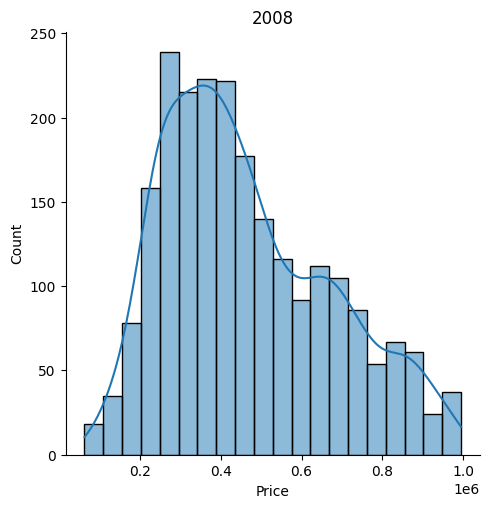

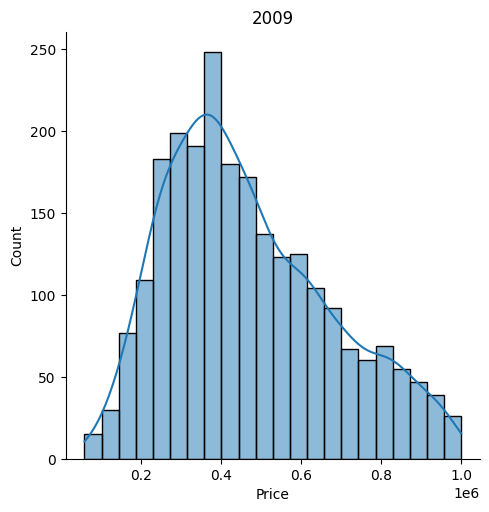

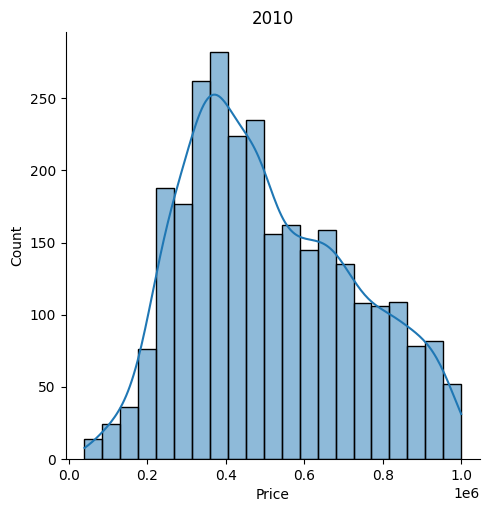

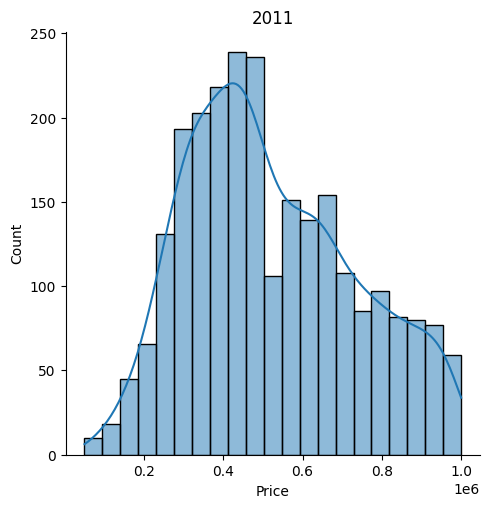

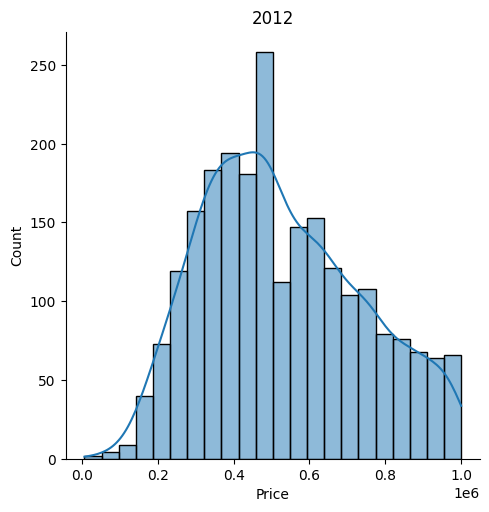

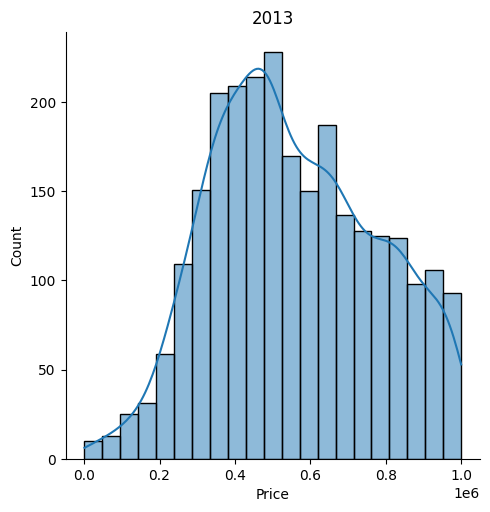

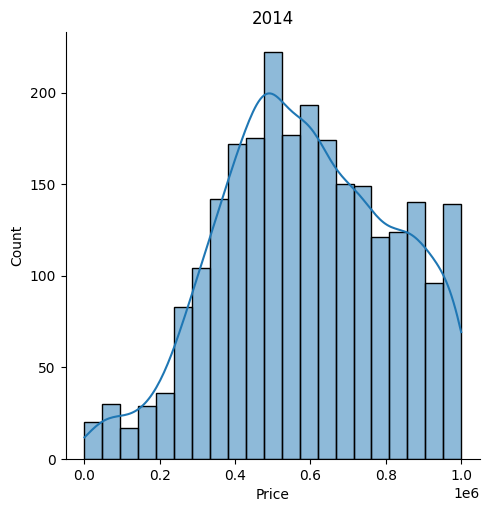

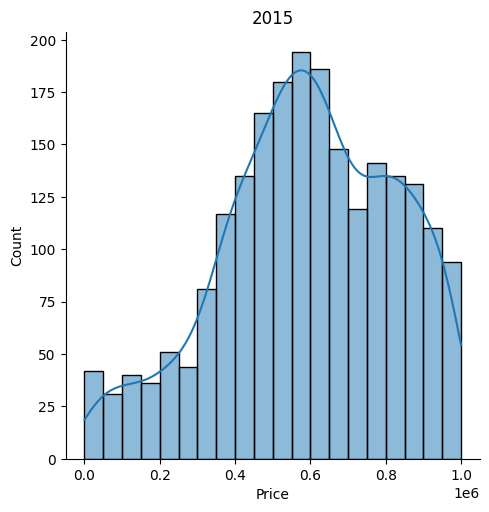

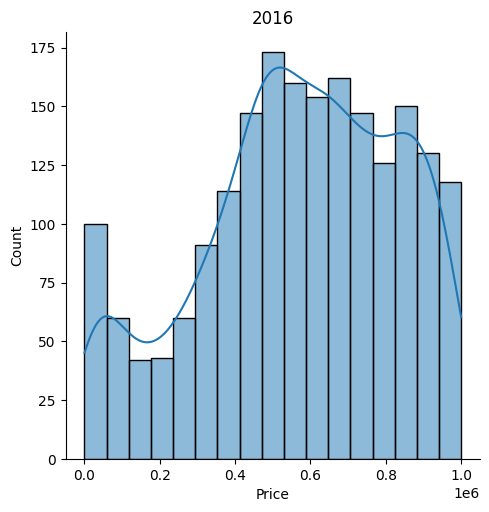

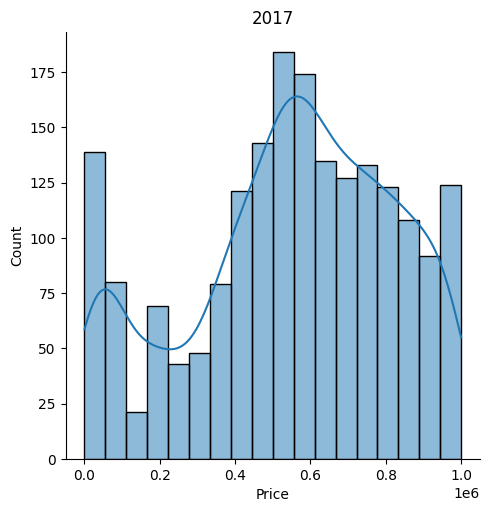

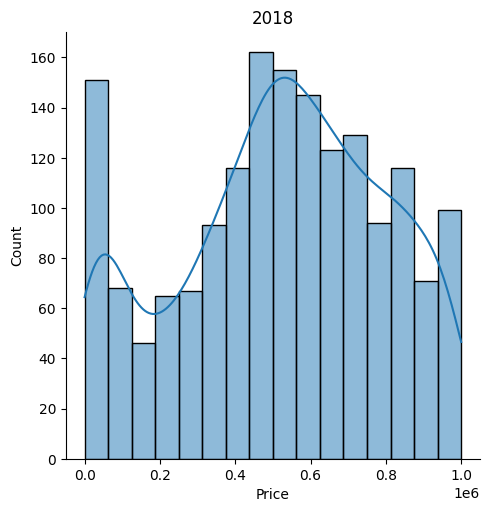

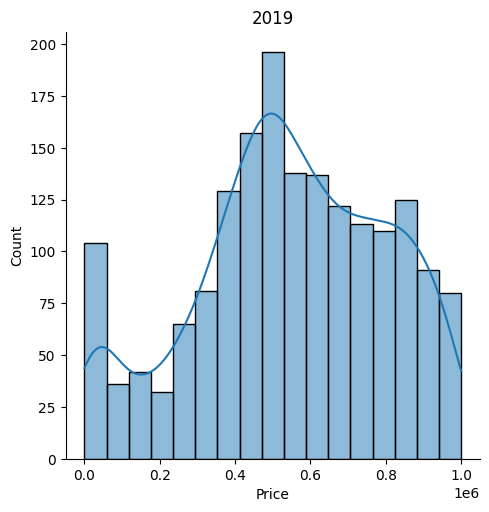

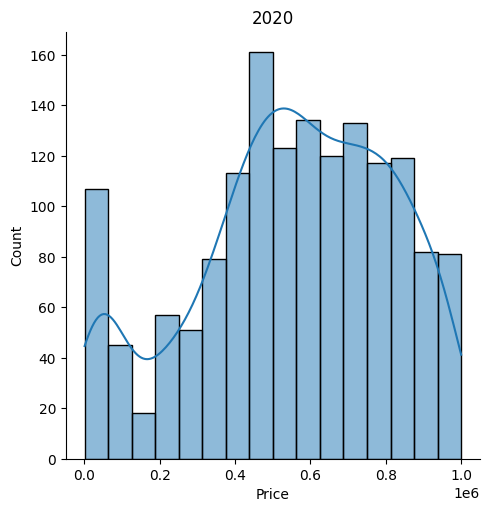

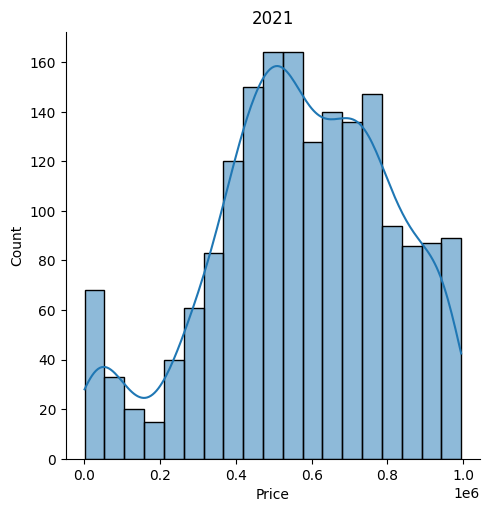

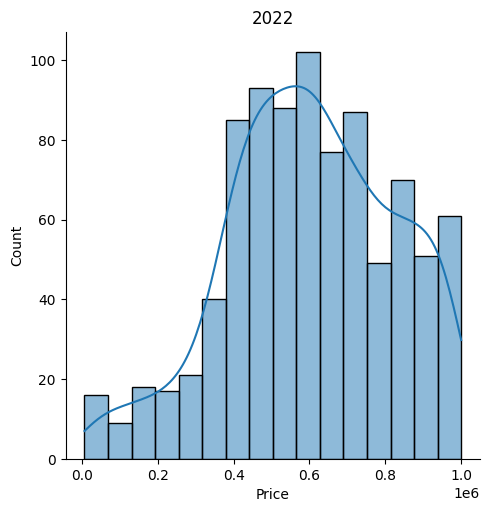

In [ ]:
# Distribution of Prices under 100,000
for i in range(len(allYearDf)) :
    
    g = sns.displot(allYearDf[i][cityOfLondonYears[i]][allYearDf[i][cityOfLondonYears[i]]["Price"] < 1000000]["Price"],kde = True)
    plt.title(cityOfLondonYears[i])
    
